## Multimodal RAG with Video Data using KDB.AI, Voyage AI and OpenAI

##### Note: This example requires a KDB.AI endpoint/API key, Voyage AI API key, and OpenAI API key. Sign up for free accounts if needed.

This notebook demonstrates building a multimodal Retrieval-Augmented Generation (RAG) system capable of answering questions about video content. It leverages:
*   **pytubefix & moviepy:** To download and process video (extract frames and audio).
*   **OpenAI Whisper:** To transcribe the video's audio content.
*   **Voyage AI:** To generate multimodal embeddings (`voyage-multimodal-3`) representing both text and image frames from video segments.
*   **KDB.AI:** As the vector database to store and search these multimodal embeddings efficiently.
*   **OpenAI GPT-4o-mini:** As the Large Language Model (LLM) to generate answers based on the retrieved multimodal context.

### Agenda:
0.  Setup
1.  Data Preparation (Download, Extraction, Transcription, Chunking)
2.  Multimodal Embedding Generation
3.  Set Up KDB.AI Vector Database Table
4.  Insert Data into KDB.AI
5.  Define RAG Helper Functions
6.  Perform Retrieval Augmented Generation
7.  Cleanup

Relevant Links:
*   [KDB.AI](https://kdb.ai/)
*   [Voyage AI](https://www.voyageai.com/)
*   [OpenAI](https://openai.com/)

## 0. Setup

Install required packages, import libraries, set up API credentials, and initialize clients.

### Installing Required Dependencies
Installs necessary Python packages including kdbai-client, pytubefix for YouTube downloads, moviepy for video processing, pillow for image handling, pandas/numpy for data manipulation, openai for LLM/Whisper access, and voyageai for multimodal embeddings. Also installs the ffmpeg system dependency required by moviepy.

In [ ]:
!pip install --quiet kdbai-client pytubefix moviepy==1.0.3 pillow pandas numpy openai \
&& apt-get update -qq && apt-get install -qq -y ffmpeg \
&& pip install --upgrade --no-deps voyageai>=0.3.2

### Upgrading NumPy
Upgrades NumPy to a specific version (1.26.4) to ensure compatibility with other dependencies, particularly relevant after installing multiple packages.

In [2]:
!pip install numpy==1.26.4 --upgrade

After this step you currently need to restart your runtime!

### Importing Core Libraries
Imports essential Python libraries for OS interaction, math operations, JSON/Base64 encoding, image handling (PIL), video editing (moviepy), data manipulation (pandas/numpy), interaction with external APIs (voyageai, openai, kdbai_client), YouTube downloading (pytubefix), user input (getpass), and rich display formatting (IPython).

In [28]:
import os
import math
import json
import base64
import getpass
from io import BytesIO

# Third-party Libraries
import voyageai
import pandas as pd
import numpy as np
from PIL import Image
from moviepy.editor import VideoFileClip
from openai import OpenAI
from pytubefix import YouTube
from pytubefix.cli import on_progress
from IPython.display import Image as IPImage, display, Markdown
import kdbai_client as kdbai

# KDB.AI Client
from kdbai_client import Session

### Setting Up API Keys and KDB.AI Connection Details
Retrieves API keys for Voyage AI, KDB.AI, and OpenAI, along with the KDB.AI endpoint URL. It first checks if the corresponding environment variable is set. If not, it securely prompts the user for the necessary credential using `getpass` (for keys) or `input` (for the endpoint) and stores it in `os.environ` for the current session.

In [ ]:
# Check for Voyage AI API Key
os.environ["VOYAGEAI_API_KEY"] = (
    os.getenv("VOYAGEAI_API_KEY")
    or getpass.getpass("Voyage AI API Key: ")
)

# Check for KDB.AI API Key
os.environ["KDBAI_API_KEY"] = (
    os.getenv("KDBAI_API_KEY")
    or getpass.getpass("KDB.AI API Key: ")
)

# Check for KDB.AI Endpoint URL
os.environ["KDBAI_ENDPOINT"] = (
    os.getenv("KDBAI_ENDPOINT")
    or input("KDB.AI Endpoint URL: ")
)

# Check for OpenAI API Key
os.environ["OPENAI_API_KEY"] = (
    os.getenv("OPENAI_API_KEY")
    or getpass.getpass("OpenAI API Key: ")
)

### Initializing API Clients and KDB.AI Session
Creates client instances for Voyage AI and OpenAI (which automatically use the API keys set in environment variables). Establishes a connection (session) to the specified KDB.AI endpoint using its API key and gets a handle to the 'default' database.

In [14]:
# Initialize Voyage AI Client
voyage = voyageai.Client(api_key=os.getenv("VOYAGEAI_API_KEY"))
print("Voyage AI Client initialized.")

# Initialize KDB.AI Session and Database connection
session = Session(endpoint=os.getenv("KDBAI_ENDPOINT"), api_key=os.getenv("KDBAI_API_KEY"))
db = session.database("default")
print(f"KDB.AI Session initialized for endpoint: {os.getenv('KDBAI_ENDPOINT')}")

# Initialize OpenAI Client
openai = OpenAI()  # Reads from os.environ["OPENAI_API_KEY"]
print("OpenAI Client initialized.")

Voyage AI Client initialized.
KDB.AI Session initialized for endpoint: https://cloud.kdb.ai/instance/bbdfv0a29f
OpenAI Client initialized.


markdown
## 1. Data Preparation

Download the target YouTube video, extract its visual frames and audio track, transcribe the audio, and then segment the video into logical chunks containing both frames and their corresponding text transcription.


### 1.a Download Video

Defines the YouTube video URL and the local path where the video file will be saved. Creates the destination directory if it doesn't exist. Uses the pytubefix library to connect to YouTube, select the highest resolution stream, and download the video, showing progress via the on_progress callback.

In [ ]:
video_url = "https://www.youtube.com/watch?v=d_qvLDhkg00"  # Example: Central Limit Theorem video
output_vid = "./content/video_data/input_vid.mp4"
output_dir = os.path.dirname(output_vid)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Downloading video from {video_url} to {output_vid}...")

yt = YouTube(video_url, on_progress_callback=on_progress)
stream = yt.streams.get_highest_resolution()

if stream:
    stream.download(output_path=output_dir, filename=os.path.basename(output_vid))
    print(f"\nVideo downloaded successfully to {output_vid}")
else:
    print("Error: Could not find a suitable video stream.")


Video downloaded successfully to /content/video_data/input_vid.mp4


### 1.b Extract Frames and Audio

Defines paths for the output frame directory and the audio file. Uses the moviepy library to open the downloaded video file. Extracts frames at a rate of 0.2 FPS (one frame every 5 seconds) and saves them as sequentially numbered PNG images. Extracts the audio track and saves it as an MP3 file with a specified codec and bitrate. Includes error handling for file processing.

In [16]:
frames_dir = os.path.join(output_dir, "frames/")
audio_mp3 = os.path.join(output_dir, "output_audio.mp3")

# Create frames directory if it doesn't exist
os.makedirs(frames_dir, exist_ok=True)

print("Extracting frames and audio...")

with VideoFileClip(output_vid) as clip:
    # Extract frames (1 frame every 5 seconds)
    clip.write_images_sequence(os.path.join(frames_dir, "frame%04d.png"), fps=0.2, logger='bar')  # Use logger='bar' for progress
    # Extract audio
    clip.audio.write_audiofile(audio_mp3, codec="libmp3lame", bitrate="192k", logger='bar')

print(f"\nFrames extracted to {frames_dir}")
print(f"Audio extracted to {audio_mp3}")

Extracting frames and audio...
Moviepy - Writing frames /content/video_data/frames/frame%04d.png.


Moviepy - Done writing frames /content/video_data/frames/frame%04d.png.
MoviePy - Writing audio in /content/video_data/output_audio.mp3


MoviePy - Done.

Frames extracted to /content/video_data/frames/
Audio extracted to /content/video_data/output_audio.mp3


### 1.c Transcribe Audio

Checks if the OpenAI client and audio file are available. Opens the extracted MP3 audio file in binary read mode and sends it to OpenAI's Whisper-1 transcription model. Requests the 'verbose_json' format to get detailed output, including word-level timestamps which might be useful for more precise alignment (though not used directly for chunking in this version). Handles potential API errors.

In [ ]:
transcription_result = None  # Initialize transcription result

print(f"Transcribing audio file: {audio_mp3} using Whisper-1...")

with open(audio_mp3, "rb") as audio_file_handle:
    transcription_result = openai.audio.transcriptions.create(
        model="whisper-1",
        file=audio_file_handle,
        response_format="verbose_json",
        timestamp_granularities=["segment"]  # Requesting segment timestamps
    )

print("Audio transcription complete.")
print(transcription_result)

### 1.d Create Video Chunks

Creates logical segments (chunks) of the video. It groups paths to 6 consecutive frames (representing ~30 seconds based on 0.2 FPS extraction). It then splits the full transcription text into sentences and distributes these sentences as evenly as possible across the frame chunks. Stores the image paths (list) and corresponding text (string) for each chunk in a Pandas DataFrame.

In [103]:
# --- 1.d  Create Video Chunks (NLTK, sentence‑aware, true punctuation) ------
import os, re, math, pandas as pd
from IPython.display import display
import nltk

##############################################################################
# Configuration
##############################################################################
FRAMES_DIR       = frames_dir     # from step 1.b
FRAME_FPS        = 0.2            # write_images_sequence fps
TARGET_CHUNK_SEC = 30             # desired chunk length
SLACK_FACTOR     = 1.20           # allow up to 20 % over‑run before forcing cut
##############################################################################

print("\n--- Building sentence‑aligned ~30 s chunks ---")

# ---------------------------------------------------------------------------
# 0. Make sure the Punkt model is present
# ---------------------------------------------------------------------------
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)
from nltk.tokenize import sent_tokenize

# ---------------------------------------------------------------------------
# 1. Frame paths and helper
# ---------------------------------------------------------------------------
frame_paths = sorted(
    [os.path.join(FRAMES_DIR, f) for f in os.listdir(FRAMES_DIR) if f.endswith(".png")],
    key=lambda p: int(re.search(r"frame(\d+)\.png", os.path.basename(p)).group(1))
)
def idx_from_time(t):   return int(round(t * FRAME_FPS))

# ---------------------------------------------------------------------------
# 2. Build per‑sentence list with *estimated* timestamps
# ---------------------------------------------------------------------------
sentences = []   # list of dict(start, end, sentence)
for seg in transcription_result.segments:
    seg_start, seg_end, seg_text = seg.start, seg.end, seg.text
    seg_sents = sent_tokenize(seg_text)

    # Distribute the segment’s duration across its sentences by char length
    seg_dur    = seg_end - seg_start
    char_total = sum(len(s) for s in seg_sents)
    running_t  = seg_start
    for s in seg_sents:
        char_frac  = len(s) / char_total
        sent_end   = running_t + char_frac * seg_dur
        sentences.append({"start": running_t, "end": sent_end, "sentence": s})
        running_t = sent_end

print(f"  • {len(sentences):,} sentences total")

# ---------------------------------------------------------------------------
# 3. Pack sentences into chunks  (guarantee ending punctuation)
# ---------------------------------------------------------------------------
chunks, cur_sents = [], []
cur_start, cur_end = None, None

def ends_with_stop(txt): return txt[-1] in ".?!"

for sent in sentences:
    if not cur_sents:                            # start new chunk
        cur_sents  = [sent]
        cur_start, cur_end = sent["start"], sent["end"]
        continue

    prospective_end  = sent["end"]
    prospective_span = prospective_end - cur_start

    # Decide if we should append sentence to current chunk
    if prospective_span <= TARGET_CHUNK_SEC * SLACK_FACTOR or not ends_with_stop(cur_sents[-1]["sentence"]):
        cur_sents.append(sent)
        cur_end = prospective_end
    else:
        chunks.append({"start": cur_start, "end": cur_end, "sentences": cur_sents})
        cur_sents  = [sent]
        cur_start, cur_end = sent["start"], sent["end"]

if cur_sents:
    chunks.append({"start": cur_start, "end": cur_end, "sentences": cur_sents})

print(f"  • {len(chunks)} chunks produced "
      f"(avg {sum(c['end']-c['start'] for c in chunks)/len(chunks):.1f}s)")

# ---------------------------------------------------------------------------
# 4. Attach frames to each chunk
# ---------------------------------------------------------------------------
records = []
total_imgs = 0
for idx, ch in enumerate(chunks):
    start_t, end_t = ch["start"], ch["end"]

    first_idx = idx_from_time(start_t)
    last_idx  = max(idx_from_time(end_t) - 1, first_idx)   # inclusive
    imgs      = frame_paths[first_idx : last_idx + 1]
    total_imgs += len(imgs)

    chunk_text = " ".join(s["sentence"] for s in ch["sentences"]).strip()

    records.append(
        {
            "section":    idx,
            "start_time": round(start_t, 2),
            "end_time":   round(end_t,   2),
            "images":     imgs,
            "text":       chunk_text,
        }
    )

print(f"  • {total_imgs} total images linked")

# ---------------------------------------------------------------------------
# 5. DataFrame
# ---------------------------------------------------------------------------
df_aligned = pd.DataFrame(records)
pd.set_option("display.max_colwidth", None)
display(df_aligned.head(10))
# ---------------------------------------------------------------------------



--- Building sentence‑aligned ~30 s chunks ---
  • 179 sentences total
  • 22 chunks produced (avg 35.2s)
  • 155 total images linked


section  start_time  end_time  \
0        0         0.0      48.3   
1        1        48.3      80.2   
2        2        80.2     112.8   
3        3       112.8     153.9   
4        4       153.9     190.5   
5        5       190.5     224.7   
6        6       224.7     257.9   
7        7       257.9     291.3   
8        8       291.3     327.3   
9        9       327.3     365.8   

                                                                                                                                                                                                                                                                                                                                                                                                                                 images  \
0  [/content/video_data/frames/frame0000.png, /content/video_data/frames/frame0001.png, /content/video_data/frames/frame0002.png, /content/video_data/frames/frame0003.png, /content/video_data/frames/frame0004.png, /content/video_data/frames/frame0005.png, /content/video_data/frames/frame0006.png, /content/video_data/frames/frame0007.png, /content/video_data/frames/frame0008.png, /content/video_data/frames/frame0009.png]   
1                                                                                                                                                                          [/content/video_data/frames/frame0010.png, /content/video_data/frames/frame0011.png, /content/video_data/frames/frame0012.png, /content/video_data/frames/frame0013.png, /content/video_data/frames/frame0014.png, /content/video_data/frames/frame0015.png]   
2                                                                                                                                [/content/video_data/frames/frame0016.png, /content/video_data/frames/frame0017.png, /content/video_data/frames/frame0018.png, /content/video_data/frames/frame0019.png, /content/video_data/frames/frame0020.png, /content/video_data/frames/frame0021.png, /content/video_data/frames/frame0022.png]   
3                                                                                      [/content/video_data/frames/frame0023.png, /content/video_data/frames/frame0024.png, /content/video_data/frames/frame0025.png, /content/video_data/frames/frame0026.png, /content/video_data/frames/frame0027.png, /content/video_data/frames/frame0028.png, /content/video_data/frames/frame0029.png, /content/video_data/frames/frame0030.png]   
4                                                                                                                                [/content/video_data/frames/frame0031.png, /content/video_data/frames/frame0032.png, /content/video_data/frames/frame0033.png, /content/video_data/frames/frame0034.png, /content/video_data/frames/frame0035.png, /content/video_data/frames/frame0036.png, /content/video_data/frames/frame0037.png]   
5                                                                                                                                [/content/video_data/frames/frame0038.png, /content/video_data/frames/frame0039.png, /content/video_data/frames/frame0040.png, /content/video_data/frames/frame0041.png, /content/video_data/frames/frame0042.png, /content/video_data/frames/frame0043.png, /content/video_data/frames/frame0044.png]   
6                                                                                                                                [/content/video_data/frames/frame0045.png, /content/video_data/frames/frame0046.png, /content/video_data/frames/frame0047.png, /content/video_data/frames/frame0048.png, /content/video_data/frames/frame0049.png, /content/video_data/frames/frame0050.png, /content/video_data/frames/frame0051.png]   
7                                                                                                                                                                          [/content/video_dat

For convenience, we remove timestamps, but that is something we can add as metadata, which could also speed up filtering and allow for better citations.

In [104]:
df = df_aligned[['images', 'text']]


## 2. Multimodal Embedding Generation

Generate multimodal embeddings using Voyage AI's `voyage-multimodal-3` model. Each embedding vector will capture the combined semantic meaning of the text transcription and the visual frames within a single video chunk.

### Preparing Inputs for Voyage AI Multimodal Embedding
Iterates through the DataFrame rows (video chunks). For each chunk, it creates a list containing the chunk's text followed by PIL Image objects loaded from the associated frame file paths. Appends this list to the `inputs_for_voyage` list, which is formatted for the Voyage AI API. Includes error handling for image loading and ensures only valid chunks (with text and successfully loaded images) are added. Updates the DataFrame `df` to retain only the rows corresponding to these valid inputs.

In [105]:
inputs_for_voyage = []
valid_indices = []

for index, row in df.iterrows():
    chunk_text = row["text"]
    image_paths = row["images"]
    current_chunk_input = [chunk_text]

    images = [Image.open(p) for p in image_paths if os.path.getsize(p) > 0]

    if images:
        current_chunk_input.extend(images)
        inputs_for_voyage.append(current_chunk_input)
        valid_indices.append(index)

df = df.loc[valid_indices].reset_index(drop=True)

print("\nExample of first input structure:")
print(f"[ Text: '{inputs_for_voyage[0][0][:30]}...', Image1: {type(inputs_for_voyage[0][1])}, ... ]")


Example of first input structure:
[ Text: 'The basic function underlying ...', Image1: <class 'PIL.PngImagePlugin.PngImageFile'>, ... ]


### Generating Voyage AI Multimodal Embeddings
Checks if there are valid inputs and the Voyage AI client is available. Sends the prepared list of multimodal inputs (`inputs_for_voyage`) to the Voyage AI API using the `voyage-multimodal-3` model, specifying `input_type="document"` for indexing. Sets `truncation=True` to handle inputs exceeding model limits. Adds the returned list of embedding vectors as a new column named 'emb' to the filtered DataFrame `df`.

In [107]:
model_name = "voyage-multimodal-3"

response = voyage.multimodal_embed(
    inputs=inputs_for_voyage,
    model=model_name,
    input_type="document",
    truncation=True
)

df['emb'] = response.embeddings

pd.reset_option("display.max_colwidth")
display(df.head())

images  \
0  [/content/video_data/frames/frame0000.png, /co...   
1  [/content/video_data/frames/frame0010.png, /co...   
2  [/content/video_data/frames/frame0016.png, /co...   
3  [/content/video_data/frames/frame0023.png, /co...   
4  [/content/video_data/frames/frame0031.png, /co...   

                                                text  \
0  The basic function underlying a normal distrib...   
1  What the Central Limit Theorem says is as you ...   
2  And we spent a lot of time building up two dis...   
3  After we walk through it, we'll talk about how...   
4  And if you want to consider distributions that...   

                                                 emb  
0  [0.0108642578125, -0.037109375, 0.023193359375...  
1  [0.0004634857177734375, -0.025390625, 0.013732...  
2  [0.029541015625, -0.0120849609375, 0.014404296...  
3  [0.029296875, -0.0289306640625, 0.02490234375,...  
4  [0.01708984375, -0.014404296875, 0.00564575195...

## 3. Set Up KDB.AI Vector Database Table

Define the KDB.AI table schema and configure the vector index for storing and searching the multimodal embeddings.

### Preparing DataFrame for KDB.AI Insertion
Creates a final DataFrame (`df_to_insert`) specifically for KDB.AI. It includes a unique string 'id' for each chunk, the chunk's text encoded as UTF-8 bytes ('text_bytes'), the list of associated image file paths serialized into a JSON string ('image_paths'), and the generated multimodal embedding ('emb').

In [108]:
temp_df = df.copy()
temp_df["id"] = temp_df.index.astype(str)
temp_df["text_bytes"] = temp_df["text"].str.encode("utf-8")
temp_df["image_paths"] = temp_df["images"].apply(json.dumps)

df_to_insert = temp_df[["id", "text_bytes", "image_paths", "emb"]]

display(df_to_insert.head())

id                                         text_bytes  \
0  0  b"The basic function underlying a normal distr...   
1  1  b"What the Central Limit Theorem says is as yo...   
2  2  b"And we spent a lot of time building up two d...   
3  3  b"After we walk through it, we'll talk about h...   
4  4  b"And if you want to consider distributions th...   

                                         image_paths  \
0  ["/content/video_data/frames/frame0000.png", "...   
1  ["/content/video_data/frames/frame0010.png", "...   
2  ["/content/video_data/frames/frame0016.png", "...   
3  ["/content/video_data/frames/frame0023.png", "...   
4  ["/content/video_data/frames/frame0031.png", "...   

                                                 emb  
0  [0.0108642578125, -0.037109375, 0.023193359375...  
1  [0.0004634857177734375, -0.025390625, 0.013732...  
2  [0.029541015625, -0.0120849609375, 0.014404296...  
3  [0.029296875, -0.0289306640625, 0.02490234375,...  
4  [0.01708984375, -0.014404296875, 0.00564575195...

### Defining KDB.AI Table Schema and Indexes
Defines the KDB.AI table schema listing column names ('id', 'text_bytes', 'image_paths', 'embeddings') and their corresponding KDB.AI data types ('str', 'bytes', 'str', 'float32s'). Also defines the vector index configuration: using 'qHnsw' type, named 'idx_emb', operating on the 'embeddings' column, with dimensionality derived from the first valid embedding and using Cosine Similarity ('CS') metric.

In [112]:
import numpy as np

# Grab the first embedding
first_emb = df_to_insert['emb'].iloc[0]

if isinstance(first_emb, (list, np.ndarray)):
    embedding_dim = len(first_emb)
    print(f"Using detected embedding dimension: {embedding_dim}")
else:
    embedding_dim = 1024
    print("Warning: couldn't determine embedding dimension; falling back to 1024")

# Now define schema and index with whichever dimension we ended up with
schema = [
    {"name": "id",          "type": "str"},
    {"name": "text_bytes",  "type": "bytes"},
    {"name": "image_paths", "type": "str"},
    {"name": "embeddings",  "type": "float32s"},
]

indexes = [{
    "type": "qHnsw",
    "name": "idx_emb",
    "column": "embeddings",
    "params": {"dims": embedding_dim, "metric": "CS"}
}]

print("KDB.AI schema and index defined successfully.")


Using detected embedding dimension: 1024
KDB.AI schema and index defined successfully.


### Creating KDB.AI Table
Sets the desired KDB.AI table name ('video_chunks'). Checks if a KDB.AI session and database connection exist, and if schema/indexes are defined. Attempts to drop any pre-existing table with the same name to ensure a clean state (handling potential 'table does not exist' errors). Creates the new table using the defined schema and indexes. Sets the global `table` variable to the created table object. Includes delays and verification steps.

In [113]:
try:
    db.table("video_chunks").drop()
except kdbai.KDBAIException:
    pass

table = db.create_table("video_chunks", schema=schema, indexes=indexes)
print(f"KDB.AI table '{table.name}' created successfully.")

KDB.AI table 'video_chunks' created successfully.


## 4. Insert Data into KDB.AI

Load the prepared video chunk data (IDs, text bytes, image path JSON, embeddings) into the KDB.AI vector table.

### Inserting Data into KDB.AI Table
Checks if the KDB.AI `table` object exists and if the `df_to_insert` DataFrame contains data. Converts the 'embeddings' column to a list of lists suitable for KDB.AI insertion. Performs a bulk insert using `table.insert()`. Includes error handling and verifies the insertion by querying and printing the first few rows from the table.

In [114]:
insert_payload = df_to_insert.copy()
insert_payload['embeddings'] = insert_payload['emb'].apply(lambda x: list(map(float, x)))

insert_payload = insert_payload[["id", "text_bytes", "image_paths", "embeddings"]]

table.insert(insert_payload)

display(table.query(limit=5))

id                                         text_bytes  \
0  0  b"The basic function underlying a normal distr...   
1  1  b"What the Central Limit Theorem says is as yo...   
2  2  b"And we spent a lot of time building up two d...   
3  3  b"After we walk through it, we'll talk about h...   
4  4  b"And if you want to consider distributions th...   

                                         image_paths  \
0  ["/content/video_data/frames/frame0000.png", "...   
1  ["/content/video_data/frames/frame0010.png", "...   
2  ["/content/video_data/frames/frame0016.png", "...   
3  ["/content/video_data/frames/frame0023.png", "...   
4  ["/content/video_data/frames/frame0031.png", "...   

                                          embeddings  
0  [0.010864258, -0.037109375, 0.02319336, -0.011...  
1  [0.00046348572, -0.025390625, 0.01373291, 0.00...  
2  [0.029541016, -0.012084961, 0.014404297, -0.01...  
3  [0.029296875, -0.028930664, 0.024902344, -0.03...  
4  [0.017089844, -0.014404297, 0.005645752, -0.02...

## 5. Define RAG Helper Functions

Create utility functions needed for the RAG process: one to encode image files into base64 data URLs for the OpenAI API, and another to display the retrieved multimodal context (text and images) clearly in the notebook.

### Defining Helper Functions for Image Encoding and RAG Preview Display
Defines two helper functions. `encode_base64` takes an image file path, reads the image, determines its format, and encodes it into a base64 data URL string required by OpenAI's vision models; includes error handling for missing files or encoding issues. `display_rag_preview` takes a list of dictionaries (representing retrieved text and base64 image URLs), iterates through it, and uses IPython display functions to render Markdown text and images in the notebook output for context verification.

In [115]:
def encode_base64(image_path: str) -> str:
    with open(image_path, "rb") as f:
        data = base64.b64encode(f.read()).decode('utf-8')
    ext = os.path.splitext(image_path)[1].lower().strip('.')
    mime = {"jpg": "jpeg", "jpeg": "jpeg", "png": "png", "gif": "gif", "webp": "webp"}.get(ext, "png")
    return f"data:image/{mime};base64,{data}"

def display_rag_preview(retrieved_content: list):
    print("="*20 + " Retrieved Content Preview " + "="*20)
    for item in retrieved_content:
        if item.get("type") == "input_text":
            display(Markdown(item.get("text", "")))
        elif item.get("type") == "input_image":
            header, data = item["image_url"].split(",", 1)
            display(IPImage(data=base64.b64decode(data), width=300))
    print("="*20 + " End of Retrieved Content " + "="*20)

## 6. Perform Retrieval Augmented Generation

Define the main RAG workflow function (`multimodal_rag`). This function orchestrates the process:

1. **Embeds the user's text query** using Voyage AI (`input_type="query"`).
2. **Searches the KDB.AI table** for the most relevant video chunks based on multimodal embedding similarity.
3. **Constructs a prompt for the OpenAI LLM**, combining the user's query and retrieved text segments.
4. **Merges the images** from each video chunk into a single "super image" to minimize token usage and help the LLM reason more effectively about visual context. These merged images are encoded to base64 and included in the prompt.
5. **Calls OpenAI's chat completions API (GPT-4o-mini)** to generate an answer based on the combined text and image context.
6. **Displays the retrieved context preview and the generated answer**, showing both the text and the merged images.

In [118]:
from PIL import Image

def merge_images(paths):
    images = [Image.open(p) for p in paths]
    widths, heights = zip(*(img.size for img in images))
    total_width = sum(widths)
    max_height = max(heights)

    merged = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for img in images:
        merged.paste(img, (x_offset, 0))
        x_offset += img.size[0]

    return merged

def multimodal_rag(query: str, k: int = 3) -> str:
    global table

    q_emb = voyage.multimodal_embed([[query]], model="voyage-multimodal-3", input_type="query", truncation=True).embeddings[0]
    retrieved = table.search(vectors={"idx_emb": [q_emb]}, n=k)[0]

    context = [{"type": "text", "text": f"Answer the query based only on the following video segments.\n\nQuestion: {query}\n"}]
    preview = []

    for i, row in retrieved.iterrows():
        tid = row.get('id', f'Retrieved_{i}')
        txt = row['text_bytes'].decode('utf-8')
        context += [{"type": "text", "text": f"\n--- Segment {tid} Text ---"}, {"type": "text", "text": txt}]
        preview.append({"type": "input_text", "text": f"\n--- Segment {tid} Text ---\n{txt}"})

        img_paths = json.loads(row.get('image_paths', '[]'))
        if img_paths:
            merged_img = merge_images(img_paths)
            merged_img_path = "/tmp/merged_segment_image.jpg"
            merged_img.save(merged_img_path, format="JPEG")

            base64_img = encode_base64(merged_img_path)
            context += [{"type": "image_url", "image_url": {"url": base64_img}}]

            preview.append({"type": "input_image", "image_url": base64_img})
            display(merged_img)

    context.append({"type": "text", "text": "\n--- End of Retrieved Context ---"})

    display_rag_preview(preview)

    res = openai.chat.completions.create(model="gpt-4o-mini", messages=[{"role": "user", "content": context}], max_tokens=500)
    out = res.choices[0].message.content

    display(Markdown(out))
    return out

### Running Multimodal RAG Example Query 1
Executes the `multimodal_rag` function with a specific question about the video's content ("What is the central limit theorem?"). It requests the top 4 most relevant chunks (k=4) from KDB.AI to provide context for the answer generation by GPT-4o-mini.


Executing RAG for query: 'What is the central limit theorem?'


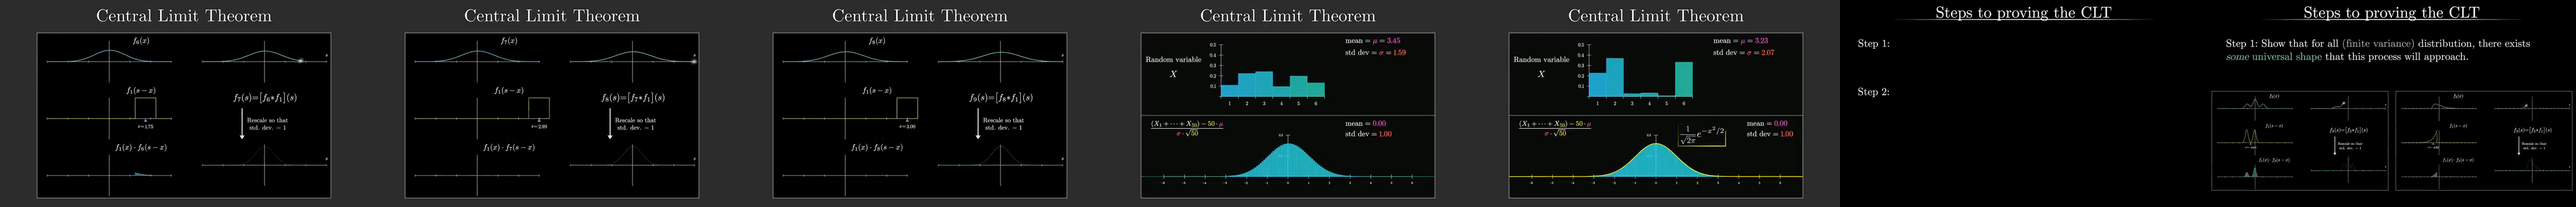

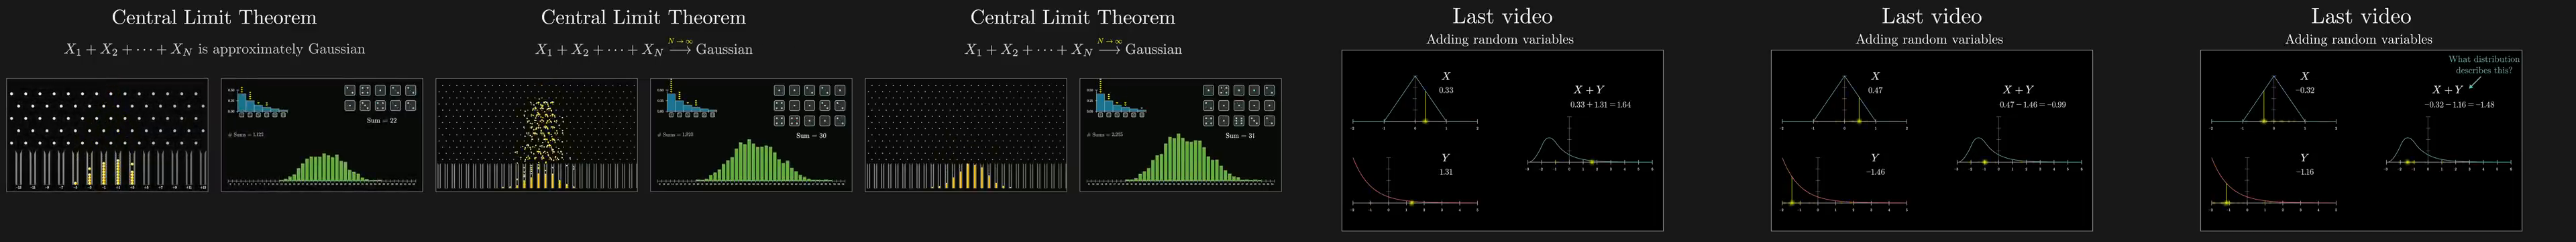

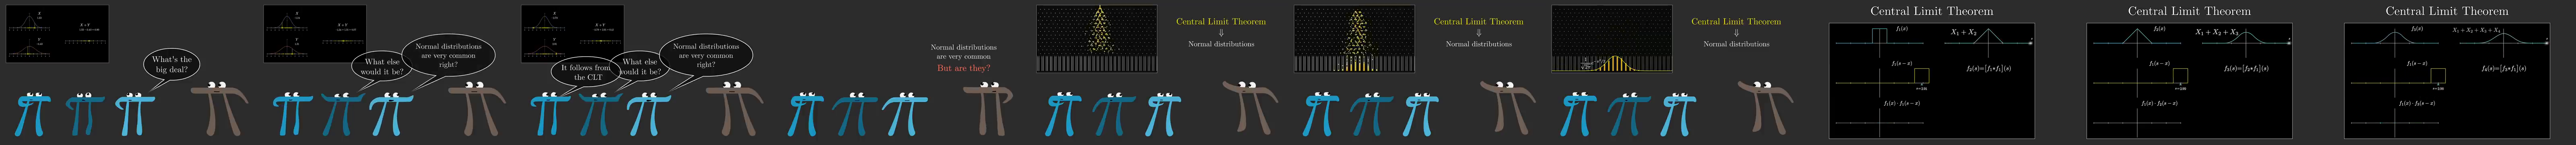

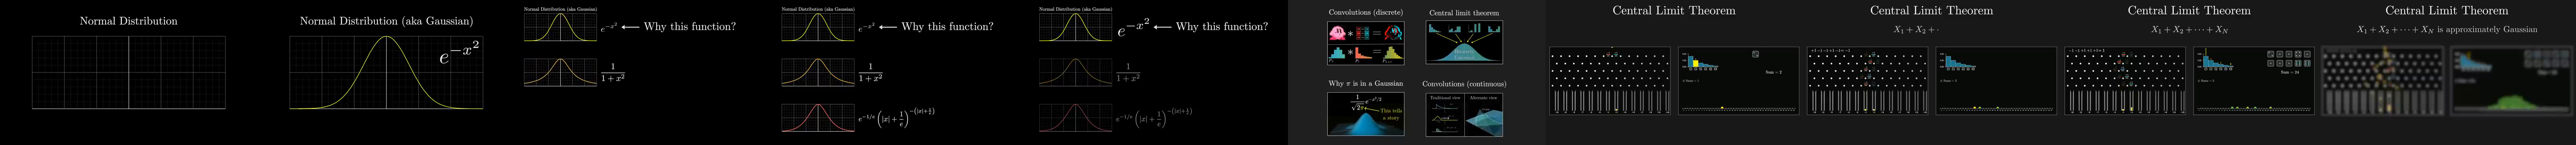

==================== Retrieved Content Preview ====================



--- Segment 17 Text ---
Technically, there's a small assumption, the distribution you start with can't have infinite variance,  but it's a relatively soft assumption.  The magic is that for a huge category of initial distributions,  this process of adding a whole bunch of random variables drawn from that distribution  always tends towards this one universal shape, a Gaussian.  One common approach to proving this theorem involves two separate steps.  The first step is to show that for all the different finite variance distributions you might start with,  there exists a single universal shape that this process of repeated convolutions tends towards.

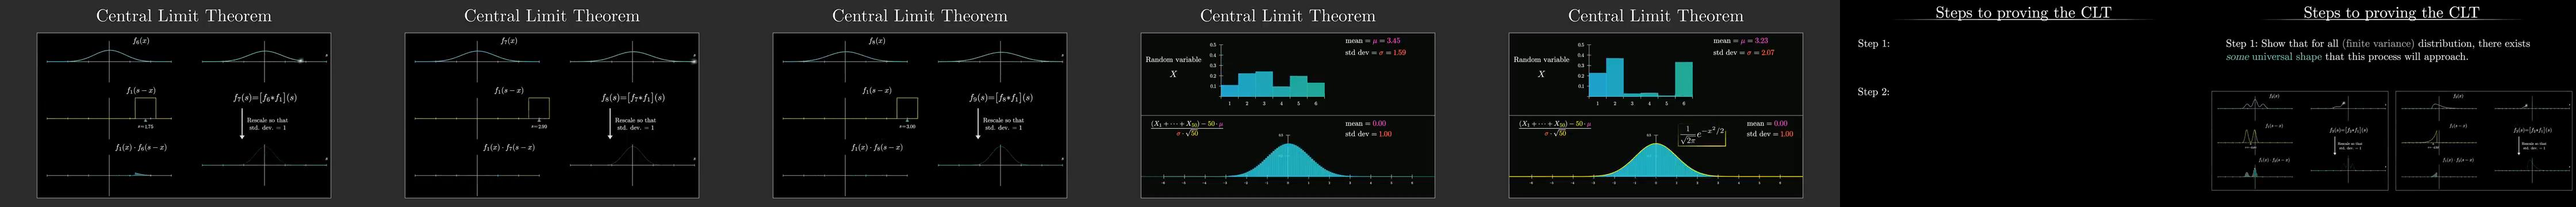


--- Segment 1 Text ---
What the Central Limit Theorem says is as you make that sum bigger and bigger, under appropriate conditions,  that approximation to a normal becomes better and better.  But I never explained why this theorem is actually true, we only talked about what it's claiming.  In the last video, we started talking about the math involved in adding two random variables.  If you have two random variables, each following some distribution,  then to find the distribution describing the sum of those variables,  you compute something known as a convolution between the two original functions.

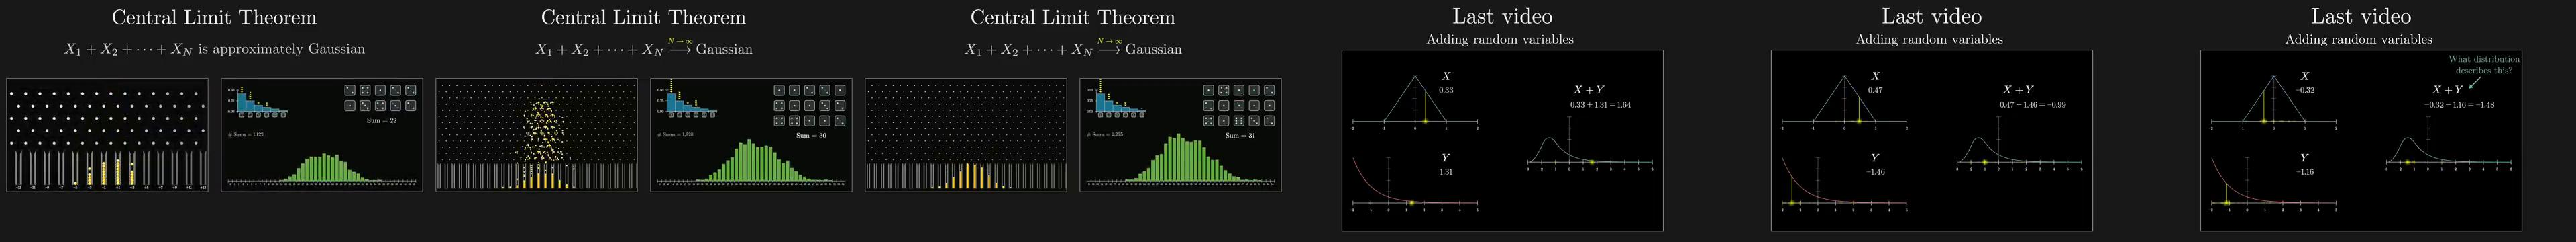


--- Segment 16 Text ---
Normal distributions are supposedly quite common, so why not?  And you could even say that this should follow from the central limit theorem.  But that would have it all backwards.  First of all, the supposed ubiquity of normal distributions is often a little exaggerated,  but to the extent that they do come up, it is because of the central limit theorem.  But it would be cheating to say the central limit theorem implies this result,  because this computation we just did is the reason that the function at the heart of the central limit theorem  is a Gaussian in the first place and not some other function.  We've talked all about the central limit theorem before,  but essentially it says if you repeatedly add copies of a random variable to itself,  which mathematically looks like repeatedly computing convolutions against a given distribution,  then after appropriate shifting and rescaling, the tendency is always to approach a normal distribution.

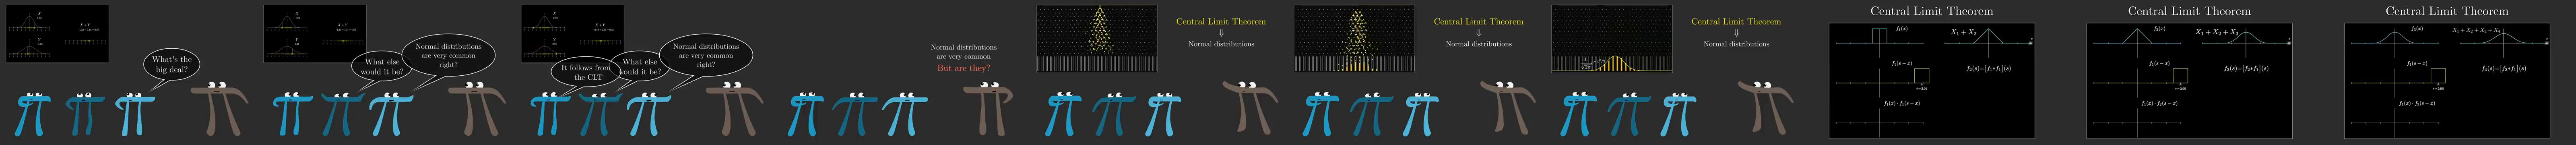


--- Segment 0 Text ---
The basic function underlying a normal distribution, a.k.a. a Gaussian, is e to the negative x-squared.  But you might wonder, why this function?  Of all the expressions we could dream up that give you some symmetric smooth graph with mass concentrated towards the middle,  why is it that the theory of probability seems to have a special place in its heart for this particular expression?  For the last many videos I've been hinting at an answer to this question,  and here we'll finally arrive at something like a satisfying answer.  As a quick refresher on where we are, a couple videos ago we talked about the Central Limit Theorem,  which describes how as you add multiple copies of a random variable,  for example, rolling a weighted die many different times or letting a ball bounce off of a peg repeatedly,  then the distribution describing that sum tends to look approximately like a normal distribution.

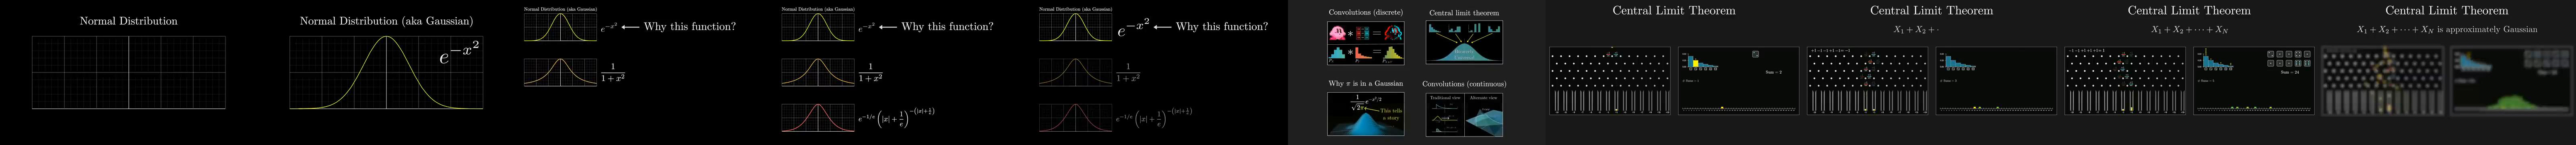

==================== End of Retrieved Content ====================


The Central Limit Theorem (CLT) states that as you repeatedly add copies of a random variable, the distribution of the sum approaches a normal distribution (or Gaussian) under certain conditions, specifically when the original distribution has finite variance. This means that regardless of the initial distribution used, as the number of added variables increases, the sum will approximate a normal distribution more closely. The theorem relies on the concept of convolutions, showing that this process leads to a single universal shape—a Gaussian curve—after appropriate shifting and rescaling.

In [ ]:
multimodal_rag('What is the central limit theorem?')


## 7. Cleanup

Remove the KDB.AI table created during this notebook session to free up resources.


### Cleanup: Dropping the KDB.AI Table
Once finished with the table, it is best practice to drop it.

In [46]:
table.drop()